In [1]:
import pandas as pd
import missingno as mno
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("output_v2.csv")
df.shape

(30515, 37)

<Axes: >

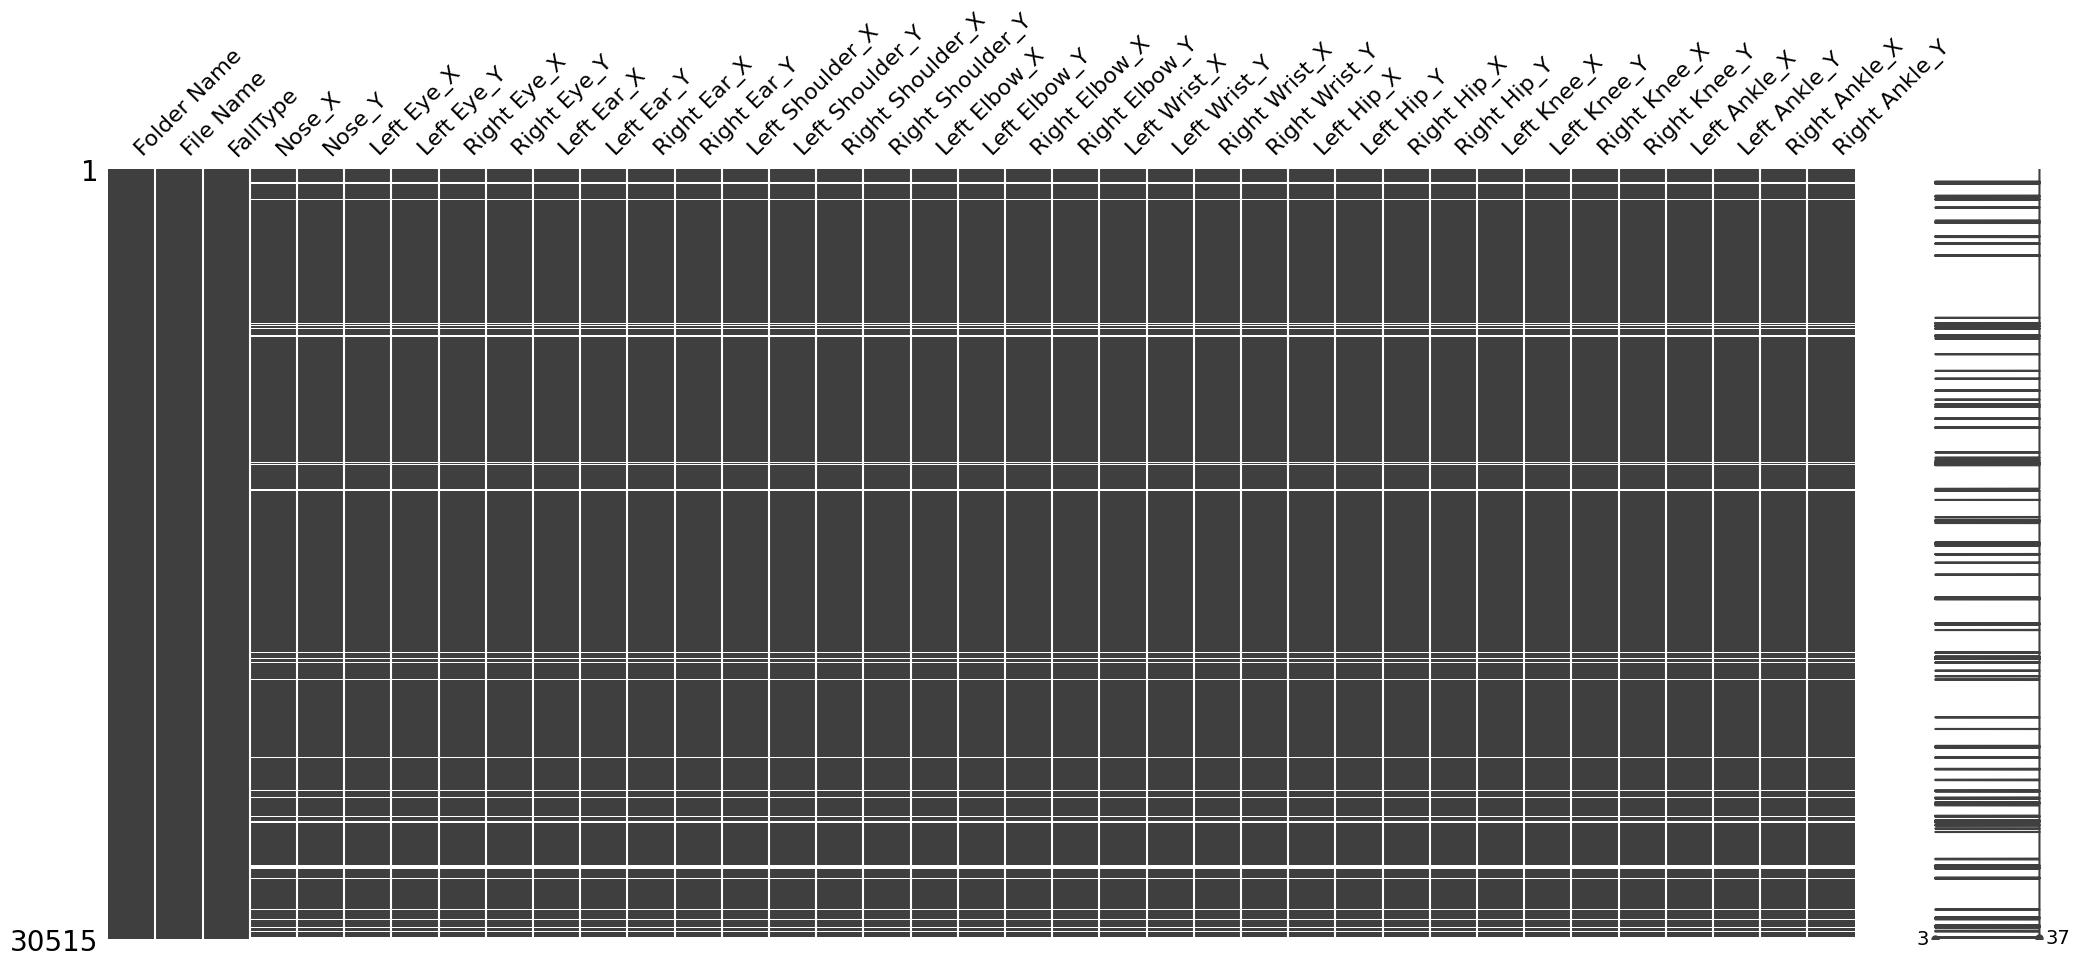

In [3]:
mno.matrix(df)


(29364, 37)

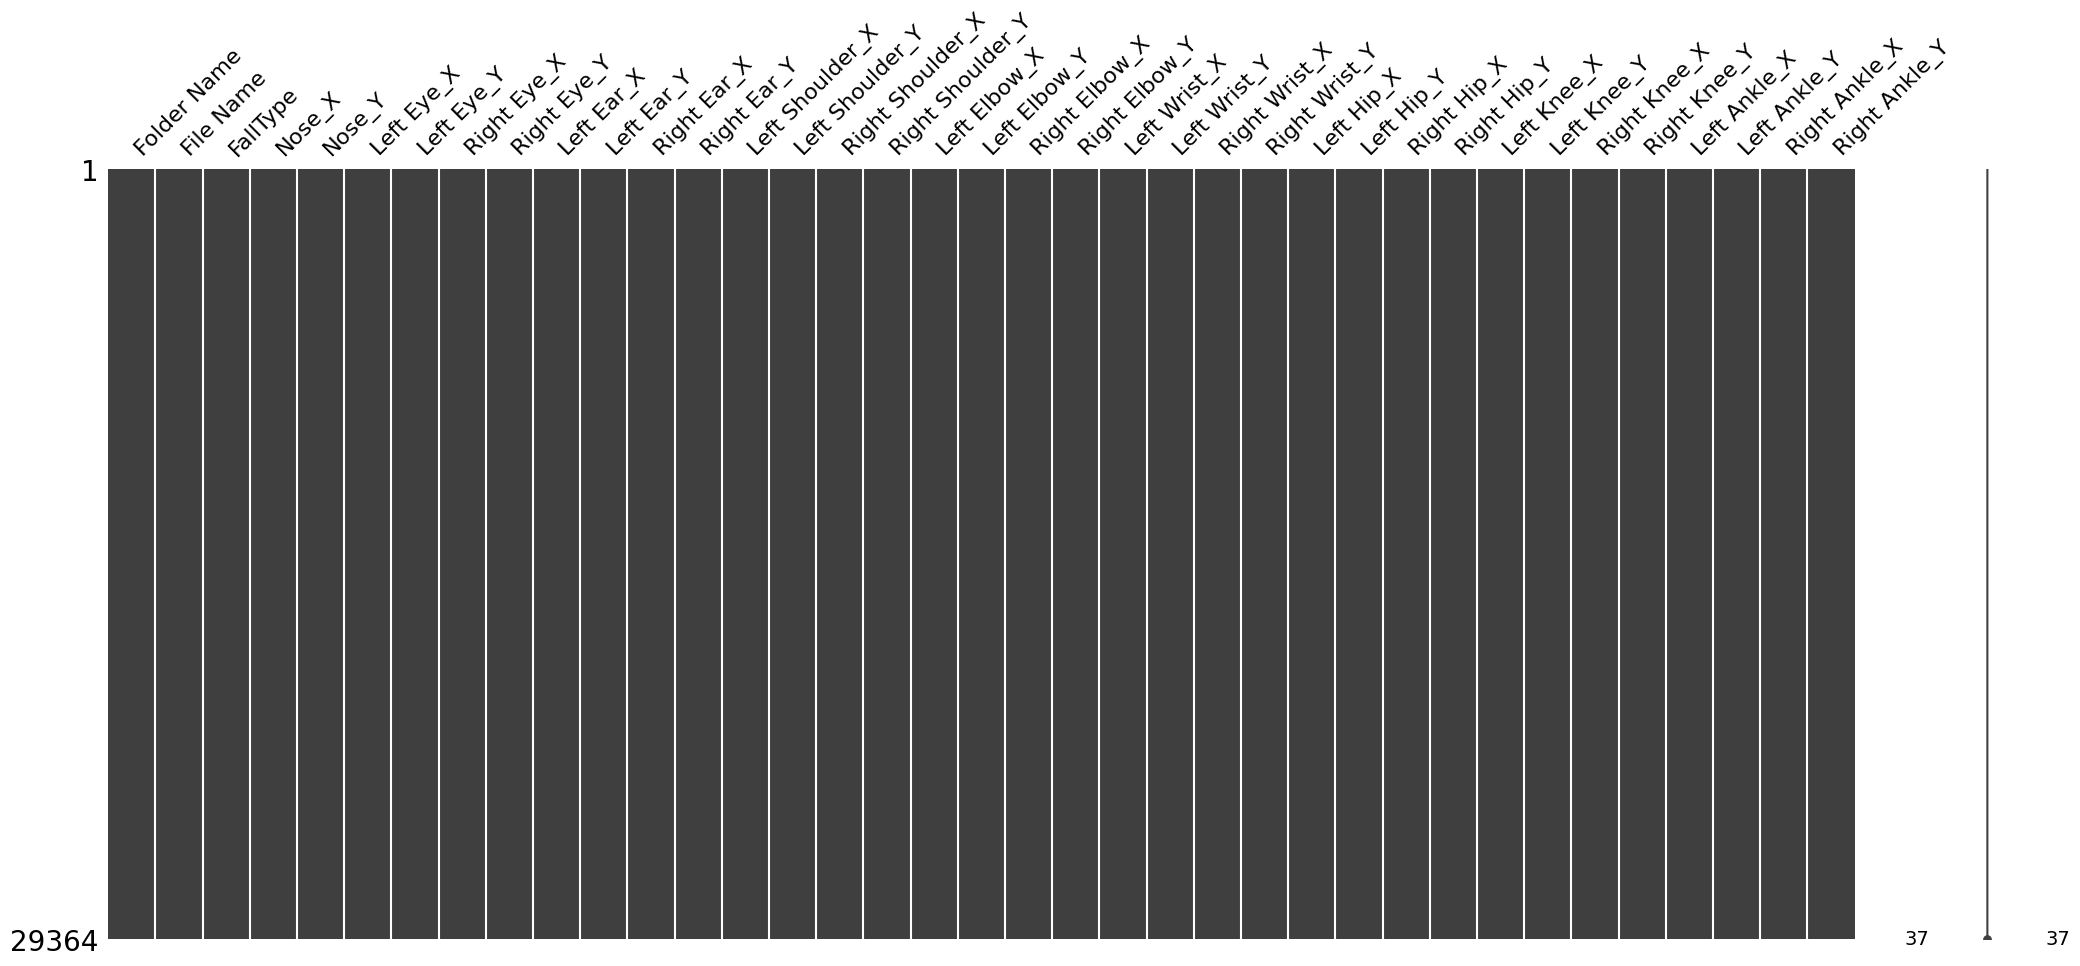

In [4]:
df_cleaned = df.dropna()
mno.matrix(df_cleaned)
df_cleaned.shape

In [5]:
df_cleaned.to_csv("remove_missingno_dataset.csv", index=False)
df_cleaned['FallType'] = df_cleaned['FallType'].replace({'NoFall': 0, 'Fall': 1})
print(df_cleaned['FallType'].unique())


[1 0]


/var/folders/k8/x32sswqj4sl36h42w9j67pb80000gn/T/ipykernel_24942/586341066.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned['FallType'] = df_cleaned['FallType'].replace({'NoFall': 0, 'Fall': 1})
/var/folders/k8/x32sswqj4sl36h42w9j67pb80000gn/T/ipykernel_24942/586341066.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['FallType'] = df_cleaned['FallType'].replace({'NoFall': 0, 'Fall': 1})


In [6]:
# Extract columns with X and Y coordinates and the target variable
coordinate_columns = [col for col in df_cleaned.columns if '_X' in col or '_Y' in col]
df_relevant = df_cleaned[['FallType'] + coordinate_columns]
correlation_matrix = df_relevant.corr()
target_correlation = correlation_matrix['FallType']
print(target_correlation)

FallType            1.000000
Nose_X             -0.158911
Nose_Y              0.100587
Left Eye_X         -0.215071
Left Eye_Y          0.064497
Right Eye_X        -0.066273
Right Eye_Y         0.163461
Left Ear_X         -0.143593
Left Ear_Y          0.150616
Right Ear_X         0.063884
Right Ear_Y         0.243203
Left Shoulder_X     0.069548
Left Shoulder_Y     0.498209
Right Shoulder_X    0.163867
Right Shoulder_Y    0.514550
Left Elbow_X       -0.053158
Left Elbow_Y        0.233608
Right Elbow_X       0.087679
Right Elbow_Y       0.276748
Left Wrist_X       -0.057449
Left Wrist_Y        0.117083
Right Wrist_X       0.068073
Right Wrist_Y       0.181676
Left Hip_X          0.035808
Left Hip_Y          0.263027
Right Hip_X         0.106889
Right Hip_Y         0.278687
Left Knee_X         0.039338
Left Knee_Y         0.052923
Right Knee_X        0.113259
Right Knee_Y        0.087314
Left Ankle_X        0.034001
Left Ankle_Y       -0.041697
Right Ankle_X       0.091527
Right Ankle_Y 

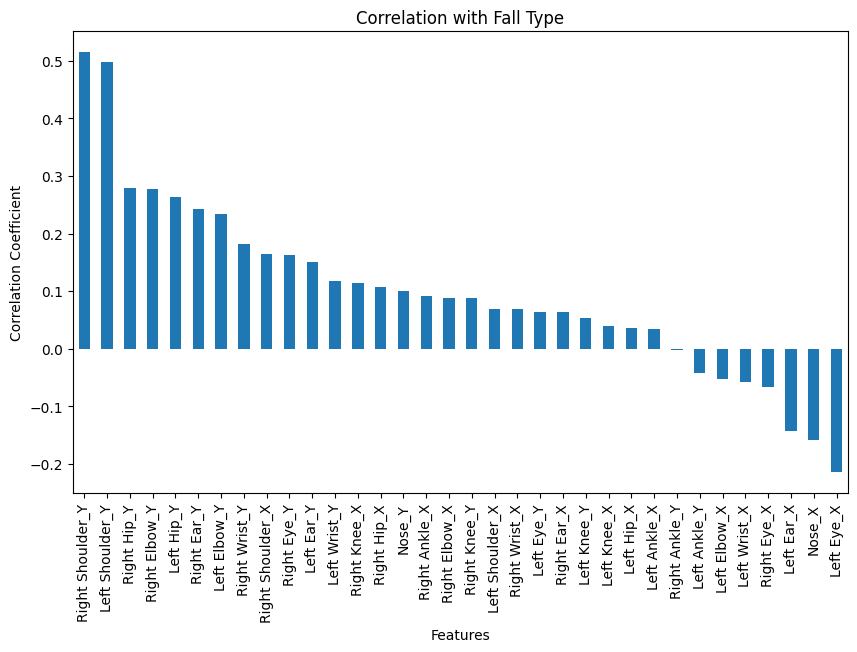

In [7]:
plt.figure(figsize=(10, 6))
target_correlation.drop('FallType').sort_values(ascending=False).plot(kind='bar')
plt.title('Correlation with Fall Type')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.show()


Class distribution:
FallType
0    18961
1    10403
Name: count, dtype: int64

Class percentages:
FallType
0    64.572265
1    35.427735
Name: proportion, dtype: float64


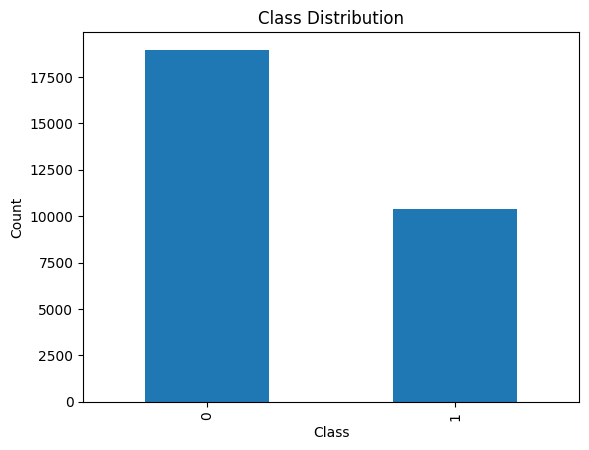

In [8]:
# Count the occurrences of each class
class_counts = df_cleaned['FallType'].value_counts()

# Print the class distribution
print("Class distribution:")
print(class_counts)

# Calculate the percentage of each class
class_percentages = df_cleaned['FallType'].value_counts(normalize=True) * 100
print("\nClass percentages:")
print(class_percentages)


# Plot class distribution
df_cleaned['FallType'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

df_cleaned.to_csv("df_cleaned.csv", index=False)


In [9]:
import numpy as np
import pandas as pd

def compute_angle(p1, p2, p3):
    """
    Compute the angle formed by three points (p1, p2, p3) where p2 is the vertex.
    """
    v1 = np.array([p1[0] - p2[0], p1[1] - p2[1]])
    v2 = np.array([p3[0] - p2[0], p3[1] - p2[1]])
    dot_product = np.dot(v1, v2)
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    cos_angle = dot_product / (magnitude_v1 * magnitude_v2)
    angle = np.degrees(np.arccos(np.clip(cos_angle, -1.0, 1.0)))
    return angle

def add_angles(df):
    def calculate_angle(row, p1_name, p2_name, p3_name):
        p1 = (row[f'{p1_name}_X'], row[f'{p1_name}_Y'])
        p2 = (row[f'{p2_name}_X'], row[f'{p2_name}_Y'])
        p3 = (row[f'{p3_name}_X'], row[f'{p3_name}_Y'])
        if all(coord != 0 for coord in p1 + p2 + p3):
            return compute_angle(p1, p2, p3)
        else:
            return np.nan

    # Head Tilt Angle (e.g., Nose between Left Eye and Right Eye)
    df['Head_Tilt_Angle'] = df.apply(lambda row: calculate_angle(row, 'Left Eye', 'Nose', 'Right Eye'), axis=1)

    # Shoulder Angle (e.g., Shoulder angles with spine)
    df['Shoulder_Angle'] = df.apply(lambda row: calculate_angle(row, 'Left Shoulder', 'Right Shoulder', 'Left Hip'), axis=1)

    # Torso Incline Angles (e.g., Hips relative to shoulders)
    df['Left_Torso_Incline_Angle'] = df.apply(lambda row: calculate_angle(row, 'Left Hip', 'Left Shoulder', 'Left Elbow'), axis=1)
    df['Right_Torso_Incline_Angle'] = df.apply(lambda row: calculate_angle(row, 'Right Hip', 'Right Shoulder', 'Right Elbow'), axis=1)

    # Elbow Angles (e.g., Shoulder-Elbow-Wrist)
    df['Left_Elbow_Angle'] = df.apply(lambda row: calculate_angle(row, 'Left Shoulder', 'Left Elbow', 'Left Wrist'), axis=1)
    df['Right_Elbow_Angle'] = df.apply(lambda row: calculate_angle(row, 'Right Shoulder', 'Right Elbow', 'Right Wrist'), axis=1)

    # Hip-Knee Angles (e.g., Hip-Knee-Ankle)
    df['Left_Hip_Knee_Angle'] = df.apply(lambda row: calculate_angle(row, 'Left Hip', 'Left Knee', 'Left Ankle'), axis=1)
    df['Right_Hip_Knee_Angle'] = df.apply(lambda row: calculate_angle(row, 'Right Hip', 'Right Knee', 'Right Ankle'), axis=1)

    # Knee-Ankle Angles (e.g., Knee-Ankle-Foot, if you have foot points)
    df['Left_Knee_Ankle_Angle'] = df.apply(lambda row: calculate_angle(row, 'Left Knee', 'Left Ankle', 'Left Hip'), axis=1)
    df['Right_Knee_Ankle_Angle'] = df.apply(lambda row: calculate_angle(row, 'Right Knee', 'Right Ankle', 'Right Hip'), axis=1)

    # Leg Spread Angle (e.g., Hips spread relative to each other)
    df['Leg_Spread_Angle'] = df.apply(lambda row: calculate_angle(row, 'Left Hip', 'Right Hip', 'Left Knee'), axis=1)

    # Head to Shoulders Angle
    df['Head_to_Shoulders_Angle'] = df.apply(lambda row: calculate_angle(row, 'Nose', 'Left Shoulder', 'Right Shoulder'), axis=1)

    # Head to Hips Angle
    df['Head_to_Hips_Angle'] = df.apply(lambda row: calculate_angle(row, 'Nose', 'Left Hip', 'Right Hip'), axis=1)

    return df

# Example usage
df_cleaned = add_angles(df_cleaned)


/var/folders/k8/x32sswqj4sl36h42w9j67pb80000gn/T/ipykernel_24942/662776300.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Head_Tilt_Angle'] = df.apply(lambda row: calculate_angle(row, 'Left Eye', 'Nose', 'Right Eye'), axis=1)
/var/folders/k8/x32sswqj4sl36h42w9j67pb80000gn/T/ipykernel_24942/662776300.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Shoulder_Angle'] = df.apply(lambda row: calculate_angle(row, 'Left Shoulder', 'Right Shoulder', 'Left Hip'), axis=1)
/var/folders/k8/x32sswqj4sl

In [10]:
print(df_cleaned.columns)
df_angles_added = df_cleaned.copy()

df_angles_added.to_csv("df_angles_added.csv", index= False)

Index(['Folder Name', 'File Name', 'FallType', 'Nose_X', 'Nose_Y',
       'Left Eye_X', 'Left Eye_Y', 'Right Eye_X', 'Right Eye_Y', 'Left Ear_X',
       'Left Ear_Y', 'Right Ear_X', 'Right Ear_Y', 'Left Shoulder_X',
       'Left Shoulder_Y', 'Right Shoulder_X', 'Right Shoulder_Y',
       'Left Elbow_X', 'Left Elbow_Y', 'Right Elbow_X', 'Right Elbow_Y',
       'Left Wrist_X', 'Left Wrist_Y', 'Right Wrist_X', 'Right Wrist_Y',
       'Left Hip_X', 'Left Hip_Y', 'Right Hip_X', 'Right Hip_Y', 'Left Knee_X',
       'Left Knee_Y', 'Right Knee_X', 'Right Knee_Y', 'Left Ankle_X',
       'Left Ankle_Y', 'Right Ankle_X', 'Right Ankle_Y', 'Head_Tilt_Angle',
       'Shoulder_Angle', 'Left_Torso_Incline_Angle',
       'Right_Torso_Incline_Angle', 'Left_Elbow_Angle', 'Right_Elbow_Angle',
       'Left_Hip_Knee_Angle', 'Right_Hip_Knee_Angle', 'Left_Knee_Ankle_Angle',
       'Right_Knee_Ankle_Angle', 'Leg_Spread_Angle', 'Head_to_Shoulders_Angle',
       'Head_to_Hips_Angle'],
      dtype='object')


In [11]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# Example DataFrame df_cleaned
# df_cleaned = pd.read_csv('your_dataset.csv')

# Step 1: Interpolation
df_angles_added.iloc[:, 3:] = df_angles_added.iloc[:, 3:].interpolate(method='linear')
df_angles_added.to_csv("df_interpolate.csv", index=False)

# Step 2: KNN Imputation
imputer = KNNImputer(n_neighbors=5)
df_angles_added.iloc[:, 3:] = imputer.fit_transform(df_angles_added.iloc[:, 3:])
df_angles_added.to_csv("df_impute.csv", index=False)

# Now df_cleaned has the missing values handled


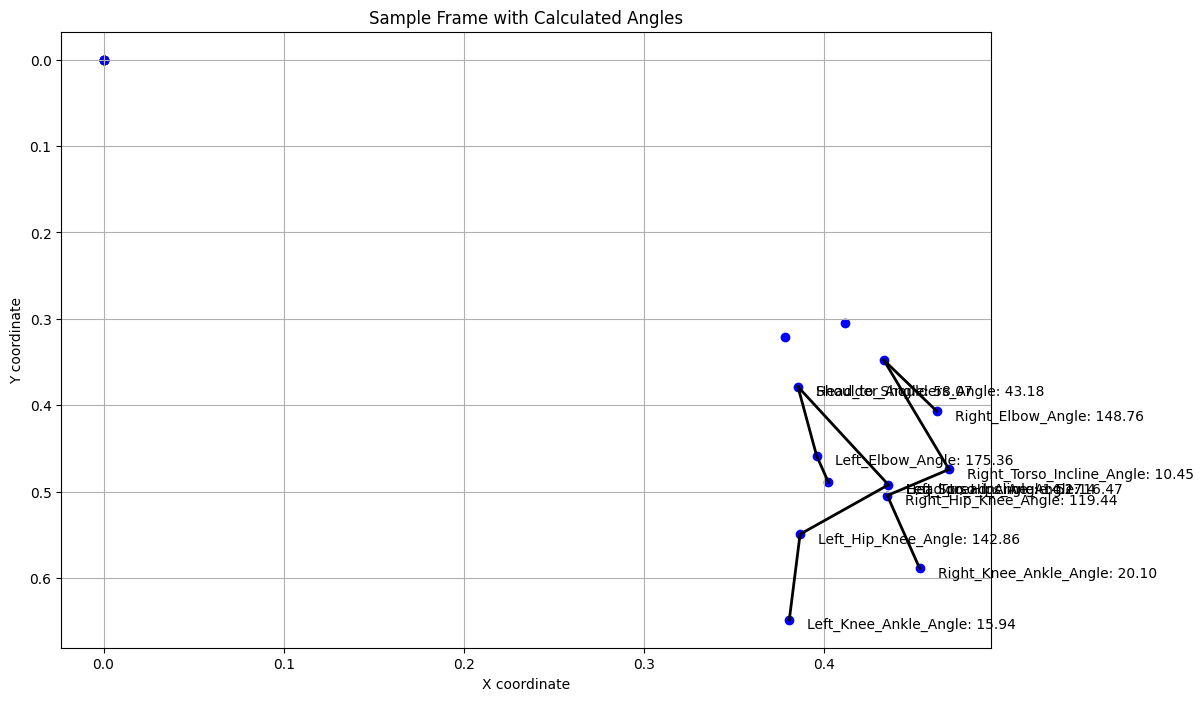

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to compute the angle between two vectors
def angle_between(v1, v2):
    """Compute the angle between two vectors in degrees."""
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    cos_theta = dot_product / (norm_v1 * norm_v2)
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip value to avoid numerical issues
    return np.degrees(angle)

# Function to calculate the vector between two points
def vector_between(p1, p2):
    """Compute the vector between two points."""
    return np.array([p2[0] - p1[0], p2[1] - p1[1]])

# Load dataset
df = pd.read_csv('df_impute.csv')  # Replace with your dataset path


# Select a sample frame
frame_index = 0  # Adjust as needed
frame = df.iloc[frame_index]

# Extract coordinates for plotting
coords = {
    'Nose': (frame['Nose_X'], frame['Nose_Y']),
    'Left Eye': (frame['Left Eye_X'], frame['Left Eye_Y']),
    'Right Eye': (frame['Right Eye_X'], frame['Right Eye_Y']),
    'Left Ear': (frame['Left Ear_X'], frame['Left Ear_Y']),
    'Right Ear': (frame['Right Ear_X'], frame['Right Ear_Y']),
    'Left Shoulder': (frame['Left Shoulder_X'], frame['Left Shoulder_Y']),
    'Right Shoulder': (frame['Right Shoulder_X'], frame['Right Shoulder_Y']),
    'Left Elbow': (frame['Left Elbow_X'], frame['Left Elbow_Y']),
    'Right Elbow': (frame['Right Elbow_X'], frame['Right Elbow_Y']),
    'Left Wrist': (frame['Left Wrist_X'], frame['Left Wrist_Y']),
    'Right Wrist': (frame['Right Wrist_X'], frame['Right Wrist_Y']),
    'Left Hip': (frame['Left Hip_X'], frame['Left Hip_Y']),
    'Right Hip': (frame['Right Hip_X'], frame['Right Hip_Y']),
    'Left Knee': (frame['Left Knee_X'], frame['Left Knee_Y']),
    'Right Knee': (frame['Right Knee_X'], frame['Right Knee_Y']),
    'Left Ankle': (frame['Left Ankle_X'], frame['Left Ankle_Y']),
    'Right Ankle': (frame['Right Ankle_X'], frame['Right Ankle_Y'])
}

# Plot the frame
plt.figure(figsize=(12, 8))
plt.scatter(*zip(*coords.values()), color='blue')

# Draw lines between joints
def draw_line(p1, p2, color='black'):
    if p1[0] != 0 and p1[1] != 0 and p2[0] != 0 and p2[1] != 0:  # Skip if any coordinate is 0
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color=color, linestyle='-', linewidth=2)

# Connect joints with lines (for visualization)
draw_line(coords['Nose'], coords['Left Shoulder'])
draw_line(coords['Nose'], coords['Right Shoulder'])
draw_line(coords['Left Shoulder'], coords['Left Elbow'])
draw_line(coords['Right Shoulder'], coords['Right Elbow'])
draw_line(coords['Left Elbow'], coords['Left Wrist'])
draw_line(coords['Right Elbow'], coords['Right Wrist'])
draw_line(coords['Left Shoulder'], coords['Left Hip'])
draw_line(coords['Right Shoulder'], coords['Right Hip'])
draw_line(coords['Left Hip'], coords['Left Knee'])
draw_line(coords['Right Hip'], coords['Right Knee'])
draw_line(coords['Left Knee'], coords['Left Ankle'])
draw_line(coords['Right Knee'], coords['Right Ankle'])

# Annotate angles on the frame
angles = {
    'Head_Tilt_Angle': ('Nose', frame['Head_Tilt_Angle']),
    'Shoulder_Angle': ('Left Shoulder', frame['Shoulder_Angle']),
    'Left_Torso_Incline_Angle': ('Left Hip', frame['Left_Torso_Incline_Angle']),
    'Right_Torso_Incline_Angle': ('Right Hip', frame['Right_Torso_Incline_Angle']),
    'Left_Elbow_Angle': ('Left Elbow', frame['Left_Elbow_Angle']),
    'Right_Elbow_Angle': ('Right Elbow', frame['Right_Elbow_Angle']),
    'Left_Hip_Knee_Angle': ('Left Knee', frame['Left_Hip_Knee_Angle']),
    'Right_Hip_Knee_Angle': ('Right Knee', frame['Right_Hip_Knee_Angle']),
    'Left_Knee_Ankle_Angle': ('Left Ankle', frame['Left_Knee_Ankle_Angle']),
    'Right_Knee_Ankle_Angle': ('Right Ankle', frame['Right_Knee_Ankle_Angle']),
    'Leg_Spread_Angle': ('Left Hip', frame['Leg_Spread_Angle']),
    'Head_to_Shoulders_Angle': ('Left Shoulder', frame['Head_to_Shoulders_Angle']),
    'Head_to_Hips_Angle': ('Left Hip', frame['Head_to_Hips_Angle'])
}

for angle_name, (joint, angle) in angles.items():
    x, y = coords[joint]
    if x != 0 and y != 0:  # Skip annotation if keypoint is at (0,0)
        plt.text(x + 0.01, y + 0.01, f'{angle_name}: {angle:.2f}', fontsize=10, ha='left')

plt.title('Sample Frame with Calculated Angles')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.gca().invert_yaxis()  # Invert Y axis to match image coordinate system
plt.grid(True)
plt.show()


In [21]:
# List of keypoint position columns
keypoint_columns = [
    'Nose_X', 'Nose_Y', 'Left Eye_X', 'Left Eye_Y', 'Right Eye_X', 'Right Eye_Y',
    'Left Ear_X', 'Left Ear_Y', 'Right Ear_X', 'Right Ear_Y', 'Left Shoulder_X', 
    'Left Shoulder_Y', 'Right Shoulder_X', 'Right Shoulder_Y', 'Left Elbow_X', 
    'Left Elbow_Y', 'Right Elbow_X', 'Right Elbow_Y', 'Left Wrist_X', 'Left Wrist_Y',
    'Right Wrist_X', 'Right Wrist_Y', 'Left Hip_X', 'Left Hip_Y', 'Right Hip_X',
    'Right Hip_Y', 'Left Knee_X', 'Left Knee_Y', 'Right Knee_X', 'Right Knee_Y',
    'Left Ankle_X', 'Left Ankle_Y', 'Right Ankle_X', 'Right Ankle_Y'
]

# Function to calculate acceleration
def calculate_acceleration(df, columns):
    df = df.sort_values(by='File Name')  # Sort by frame number
    for col in columns:
        df[f'{col}_velocity'] = df.groupby('Folder Name')[col].diff()  # Calculate the rate of change (velocity)
        df[f'{col}_acceleration'] = df.groupby('Folder Name')[f'{col}_velocity'].diff()  # Calculate the rate of change of velocity (acceleration)
    return df

# Apply the function to each folder
data_with_acceleration = df.groupby('Folder Name').apply(calculate_acceleration, keypoint_columns).reset_index(drop=True)

# Save the results to a new CSV file
data_with_acceleration.to_csv('data_with_acceleration.csv', index=False)

/var/folders/k8/x32sswqj4sl36h42w9j67pb80000gn/T/ipykernel_24942/345655153.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_with_acceleration = df.groupby('Folder Name').apply(calculate_acceleration, keypoint_columns).reset_index(drop=True)


In [22]:
data_with_acceleration.shape

(29364, 118)

<Axes: >

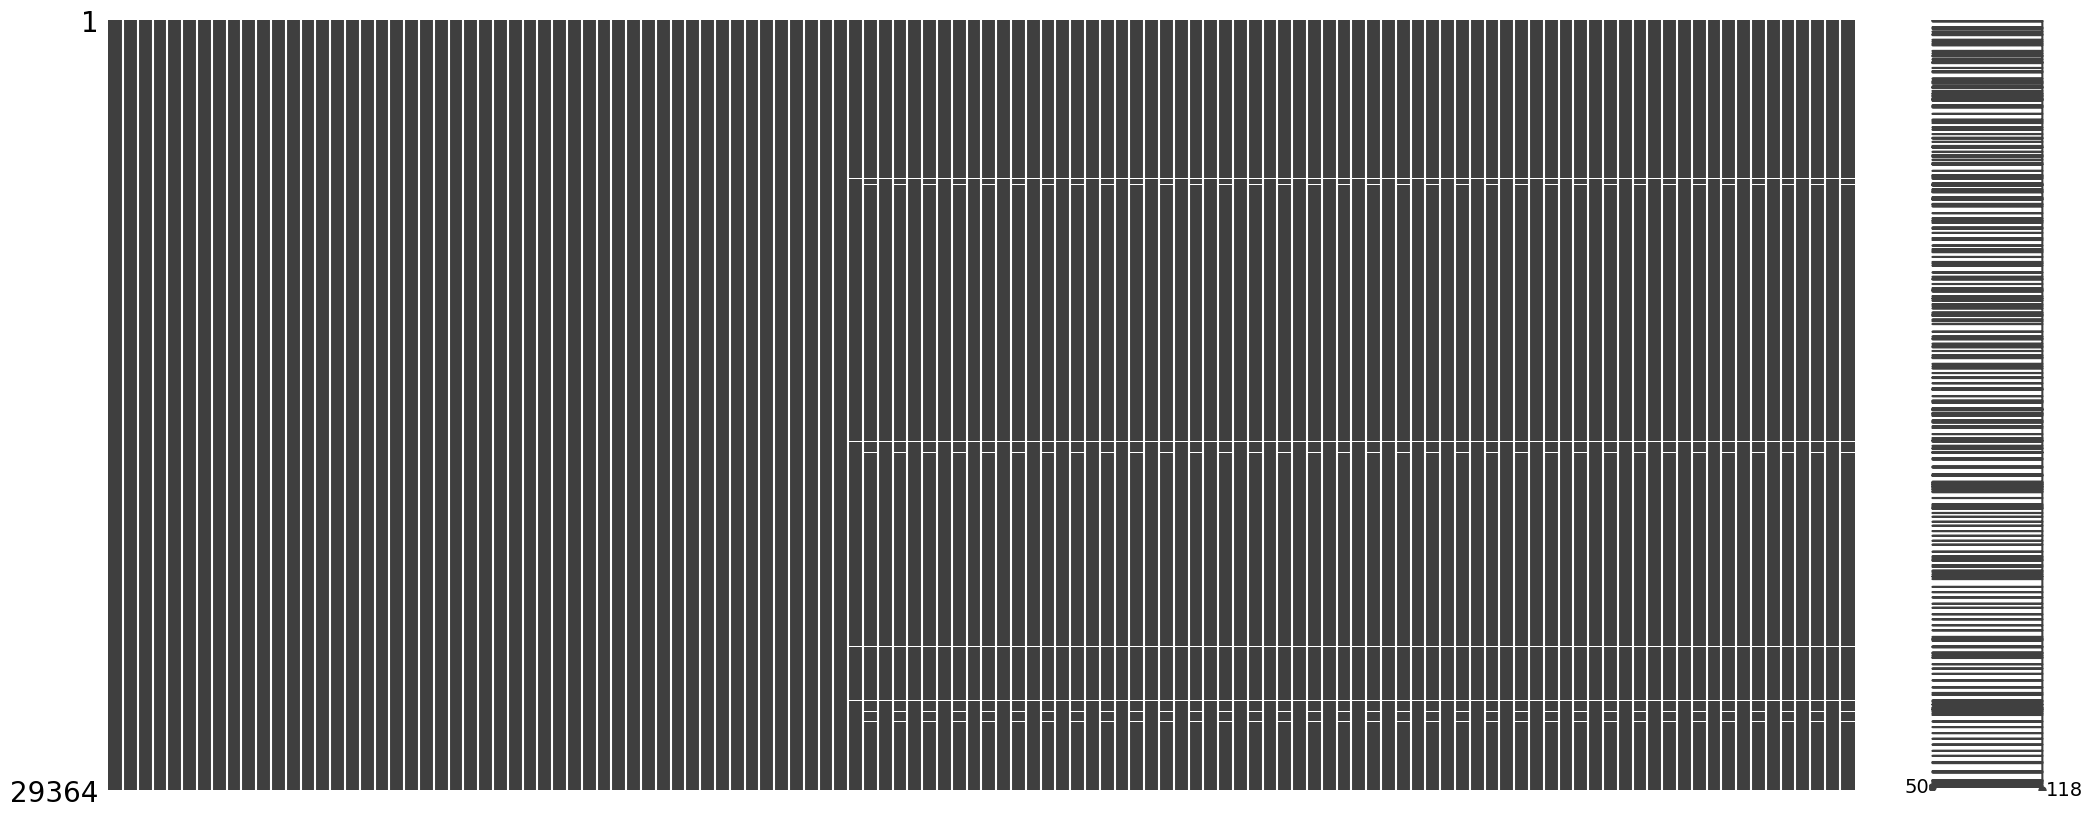

In [23]:
mno.matrix(data_with_acceleration)

In [26]:
# Step 1: Interpolation
data_with_acceleration.iloc[:, 3:] = data_with_acceleration.iloc[:, 3:].interpolate(method='linear')
data_with_acceleration.to_csv("df_interpolate_acceleration.csv", index=False)

# Step 2: KNN Imputation
imputer = KNNImputer(n_neighbors=5)
data_with_acceleration.iloc[:, 3:] = imputer.fit_transform(data_with_acceleration.iloc[:, 3:])
data_with_acceleration.to_csv("df_impute_acceleration.csv", index=False)


<Axes: >

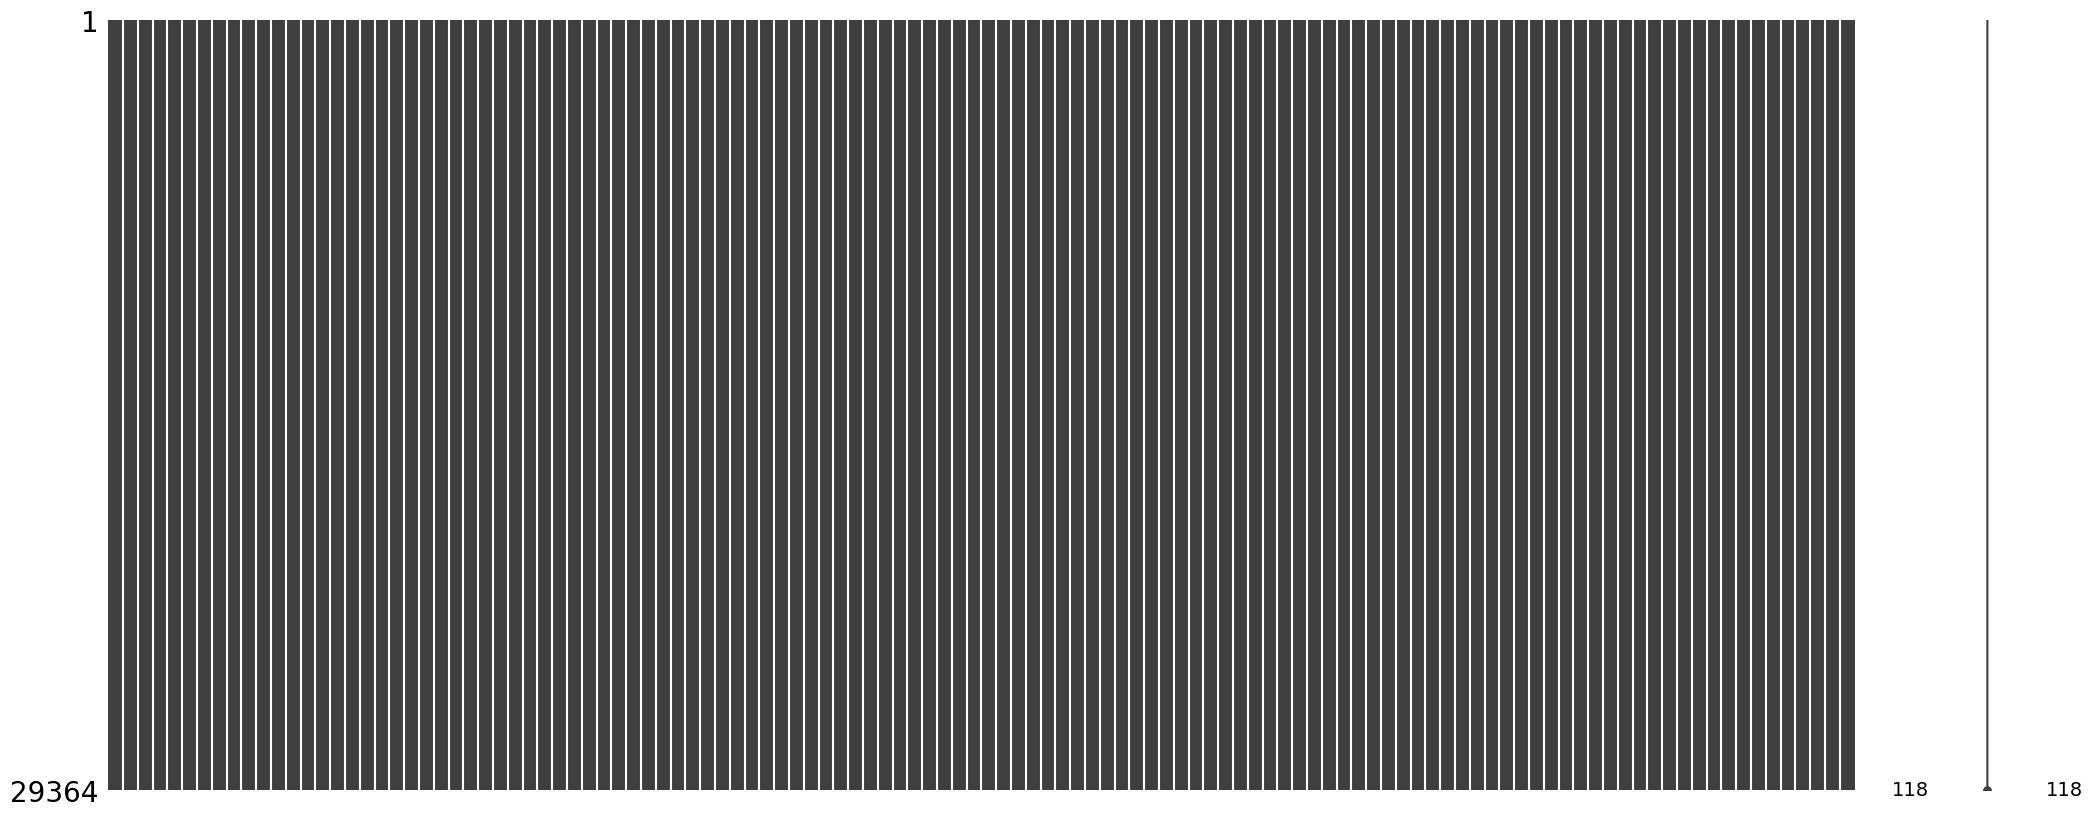

In [27]:
mno.matrix(data_with_acceleration)

In [28]:
data_with_acceleration.shape

(29364, 118)